##Research Question
The problem statement propsoed in our project proposal was:                      
“How can existing reinforcement learning architectures be improved by integrating
distributional value estimation, noise-driven exploration, and disentangling the effects of
exploration from optimization to address scalability, generalization, and real-world
applicability?”                                                                 

Here we decide to limit our scope to solving for a single Atari game environment, "DemonAttack-v5", which has been initialized above.

##Model Setup
Our approach for making the Deep Q-Network (DQN) model is by combining three different methods proposed in the research question:

1.   Dueling DQN: modifies its architecture for better state-value learning.
2.   Distributional DQN (C51): modifies the learning target from expected value to a full distribution.
3.   Noisy DQN: replaces fixed exploration heuristics (e.g., ε-greedy) with learnable noise.

We start by making different classes and functions that cover:

*   Deep Q Neural network (with Duelling and Distributional features)
*   Replay buffer
*   Noisy Layers (for noisy exploration)
*   DQN Agent
*   Categorical/Distributional RL

All the classes are then instantiated and utilized in the training loop to generate results.


##Preamble
We start by importing and installing the following dependencies needed by the code.

In [ ]:
!pip install autorom[accept-rom-license]
!pip install pyvirtualdisplay
!pip install opencv-python matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 9.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=autorom_accept_rom_license-0.6.1-py3-none-any.whl size=446710 sha256=a3d93d2941586d8def2ea8d076dae81ae487b5cb5bccf059b357c245607798a4
  Stored in directory: /root/.cache/pip/wheels/bc/fc/c6/8aa657c0d2089982f2dabd110efc68c61eb49831fdb7397351
Successfully built AutoROM.accept-rom-license
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: gym 0.25.2
Uninstalling gym-0.25.2:
  Successfully uninstalled gym-0.25.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import random
from collections import deque
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Lambda
from tensorflow.keras.layers import Layer, Activation
from tensorflow.keras.initializers import RandomUniform
from keras.optimizers import Adam
from collections import deque
import time
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym

## Replay Buffer

In [ ]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def size(self):
        return len(self.buffer)


## Noisy Dense Layer

In [ ]:
# Custom Dense layer that adds learned noise to its weights and biases
class NoisyDense(Layer):
    def __init__(self, units, sigma_init=0.5, **kwargs):
        # Removing activation function, its handled outside this layer
        kwargs.pop('activation', None)
        super(NoisyDense, self).__init__(**kwargs)

        # Number of neurons/units in this layer
        self.units = units
        # Initial value for sigma (standard deviation for noise)
        self.sigma_init = sigma_init

    def build(self, input_shape):

        input_dim = int(input_shape[-1])

        # Initialize mean of weights (mu_weight) with uniform distribution
        self.mu_weight = self.add_weight(
            name="mu_weight",
            shape=(input_dim, self.units),
            initializer=RandomUniform(-1/np.sqrt(input_dim), 1/np.sqrt(input_dim)),
            trainable=True)

        # Initialize sigma (stddev) of weights (sigma_weight) with constant value
        self.sigma_weight = self.add_weight(
            name="sigma_weight",
            shape=(input_dim, self.units),
            initializer=tf.keras.initializers.Constant(self.sigma_init / np.sqrt(input_dim)),
            trainable=True)

        # Initialize mean of biases (mu_bias)
        self.mu_bias = self.add_weight(
            name="mu_bias",
            shape=(self.units,),
            initializer=RandomUniform(-1/np.sqrt(input_dim), 1/np.sqrt(input_dim)),
            trainable=True)

        # Initialize sigma (stddev) of biases (sigma_bias)
        self.sigma_bias = self.add_weight(
            name="sigma_bias",
            shape=(self.units,),
            initializer=tf.keras.initializers.Constant(self.sigma_init / np.sqrt(input_dim)),
            trainable=True)

    def call(self, inputs):
        # Sample random noise for inputs and outputs from a normal distribution (mean=0, stddev=1)
        epsilon_in = tf.random.normal((int(inputs.shape[-1]),))
        epsilon_out = tf.random.normal((self.units,))

        # Apply the factorized Gaussian noise transformation

        f_epsilon_in = tf.sign(epsilon_in) * tf.sqrt(tf.abs(epsilon_in))
        f_epsilon_out = tf.sign(epsilon_out) * tf.sqrt(tf.abs(epsilon_out))

        # Outer product of input and output noise vectors for weight noise
        epsilon_weight = tf.einsum('i,j->ij', f_epsilon_in, f_epsilon_out)

        epsilon_bias = f_epsilon_out

        # Add noise to weights and biases: learned mean + learned stddev * sampled noise
        noisy_weight = self.mu_weight + self.sigma_weight * epsilon_weight
        noisy_bias = self.mu_bias + self.sigma_bias * epsilon_bias

        # Compute the final layer output: (inputs • noisy_weights) + noisy_bias
        return tf.matmul(inputs, noisy_weight) + noisy_bias


## DQN Agent

In [ ]:
class DQNAgent:
  def __init__(self):
    # Main model
    self.model = self.create_model()

    # Target model
    self.target_model = self.create_model()
    self.target_model.set_weights(self.model.get_weights())

    # Experience replay buffer to store (state, action, reward, next_state, done) tuples
    self.replay_memory = ReplayBuffer(REPLAY_MEMORY_SIZE)

    # Counter for updating the target network every few steps
    self.target_update_counter = 0

  # Add a new experience to the replay memory
  def update_replay_memory(self, transition):
    state, action, reward, next_state, done = transition
    self.replay_memory.add(state, action, reward, next_state, done)

  # Predict Q-values for a given state
  def get_qs(self, state, step):
    return self.model.predict(np.array(state).reshape(-1, *state.shape))[0]

  # Build the model architecture
  def create_model(self):
    # Input shape based on the environment's observation space
    input_layer = Input(shape=env.observation_space.shape)


    x = Flatten()(input_layer)

    # Add fully connected NoisyDense layers with activation
    x = NoisyDense(256)(x)
    x = Activation('relu')(x)
    x = NoisyDense(256)(x)
    x = Activation('relu')(x)

    # Value Stream: estimates the overall value of a given state
    v = NoisyDense(512)(x)
    v = Activation('relu')(v)
    v = NoisyDense(Natoms)(v)  # Natoms = number of support points for C51 distributional DQN
    v = Lambda(lambda x: tf.expand_dims(x, axis=1))(v)  # shape [batch, 1, Natoms]

    # Advantage Stream: estimates advantage of each action over the mean value
    a = NoisyDense(512)(x)
    a = Activation('relu')(a)
    a = NoisyDense(env.action_space.n * Natoms)(a)  # one atom distribution per action
    a = Lambda(lambda x: tf.reshape(x, [-1, env.action_space.n, Natoms]))(a)

    # Combine Value and Advantage streams into Q-value distribution
    def combine_va_dist(inputs):
        v, a = inputs
        a_mean = tf.reduce_mean(a, axis=1, keepdims=True)  # mean advantage per batch
        q_atoms = v + (a - a_mean)  # Q-distribution as V + (A - mean(A))
        return q_atoms

    q_atoms = Lambda(combine_va_dist)([v, a])

    # Apply softmax over the atom dimension to make valid probability distributions
    q_dist = Lambda(lambda x: tf.nn.softmax(x, axis=2))(q_atoms)

    # Compile the model
    model = Model(inputs=input_layer, outputs=q_dist)
    model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.00025))

    return model


### Distributional RL

In [ ]:
def project_distribution(next_dist, rewards, dones, gamma, z, vmin, vmax):
    batch_size = rewards.shape[0]
    Natoms = z.shape[0]
    delta_z = (vmax - vmin) / (Natoms - 1)

    # Tz: shifted support
    Tz = rewards[:, None] + gamma * (1.0 - dones[:, None]) * z[None, :]
    Tz = np.clip(Tz, vmin, vmax)

    # b: relative positions of Tz in the support
    b = (Tz - vmin) / delta_z
    l = np.floor(b).astype(int)
    u = np.ceil(b).astype(int)

    l = np.clip(l, 0, Natoms - 1)
    u = np.clip(u, 0, Natoms - 1)

    m = np.zeros((batch_size, Natoms), dtype=np.float32)

    for i in range(Natoms):
        lower_mask = (u == i)
        upper_mask = (l == i)

        m[:, i] += np.sum(next_dist * (u - b) * upper_mask, axis=1)
        m[:, i] += np.sum(next_dist * (b - l) * lower_mask, axis=1)

    return m



In [ ]:
def categorical_crossentropy_loss(target_dist, pred_dist):
    # To prevent log(0)
    pred_dist = tf.clip_by_value(pred_dist, 1e-8, 1.0)
    loss = -tf.reduce_sum(target_dist * tf.math.log(pred_dist), axis=1)  # sum over atoms
    return tf.reduce_mean(loss)

## Deep Q Network

This is where the different proposed methods are incorporated and our Deep Q Network functionality lies.

Firstly, the CartPole environment gives observations as a 4-dimensional vector representing the cart position, cart velocity, pole angle, and pole angular velocity. This 4D input is fed into two shared noisy dense layers with ReLU activations, which learn a common representation of the input features.

The results from these layers are not fed into a conventional fully connected layer, but rather into **Noisy Dense layers**, which are handled by a separate class. These layers inject parametric noise into the weights to enable more efficient and state-dependent exploration, as proposed in *"Noisy Networks for Exploration"* (Fortunato et al., 2019).

The shared features are then split into two separate streams: a **value stream** and an **advantage stream**, characteristic of the **Dueling DQN Architecture** (Wang et al., 2016). Each of these streams consists of its own Noisy Dense layers. The value stream estimates the overall value of being in a particular state, while the advantage stream estimates the relative benefit of each action. These two streams are combined using the standard dueling formula:

$$
Q(s, a) = V(s) + \left( A(s, a) - \frac{1}{|\mathcal{A}|} \sum_{a'} A(s, a') \right)
$$

Instead of predicting a scalar Q-value for each state-action pair, we use the **categorical distributional approach** from *"A Distributional Perspective on Reinforcement Learning”* (Bellemare et al., 2017). Specifically, each Q-value is modeled as a probability distribution over `51` discrete support points (called **atoms**) spaced uniformly between `v_min = 0` and `v_max = 500`.

The network outputs a probability distribution over these atoms for each action. The expected Q-value is then computed as the weighted sum of the atom values with their respective probabilities, enabling a richer representation of uncertainty and leading to better learning performance, especially in stochastic environments.

#### Model and Environment Parameters

In [ ]:
EPISODES = 500
BATCH_SIZE = 32
GAMMA = 0.99
UPDATE_TARGET_EVERY = 5
MAX_STEPS = 500
TRAIN_EVERY = 4

REPLAY_MEMORY_SIZE = 50_000
MIN_REPLAY_MEMORY_SIZE = 1_000

Natoms = 51
vmin = 0
vmax = 500
delta_z = (vmax - vmin) / (Natoms - 1)
z = np.linspace(vmin, vmax, Natoms)

env = gym.make("CartPole-v1")

### Model Implementation and Training
The following implementation relies on using the Noisy exploration startegy discussed above. It then builds upon that and implements the dueling architecture and the categorical distributional approach.

In [ ]:
agent = DQNAgent()
# Assuming state_size = env.observation_space.shape[0]
state_size = env.observation_space.shape[0]
dummy_input = np.zeros((1, state_size))
agent.model(dummy_input)

# Print the model summary before training
agent.model.summary()
episode_rewards = []
losses = []
update_steps = 0

for episode in range(EPISODES):
    start_time = time.time()

    state, _ = env.reset()
    state = np.expand_dims(state, axis=0)

    done = False
    episode_reward = 0
    episode_losses = []
    step = 0

    while not done and step < MAX_STEPS:
        # Predict action distributions
        q_dists = agent.model.predict(state, verbose=0)[0]  # [actions, atoms]
        q_values = np.sum(z * q_dists, axis=1)
        action = np.argmax(q_values)

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_state = np.expand_dims(next_state, axis=0)

        agent.update_replay_memory((state, action, reward, next_state, done))
        state = next_state
        episode_reward += reward
        step += 1

        # Train if enough data and time
        if agent.replay_memory.size() > MIN_REPLAY_MEMORY_SIZE and step % TRAIN_EVERY == 0:
            transitions = agent.replay_memory.sample(BATCH_SIZE)

            states_mb = np.vstack([t[0] for t in transitions])
            actions_mb = np.array([t[1] for t in transitions])
            rewards_mb = np.array([t[2] for t in transitions])
            next_states_mb = np.vstack([t[3] for t in transitions])
            dones_mb = np.array([t[4] for t in transitions])

            # Predict next state distributions from target model
            next_dist = agent.target_model(next_states_mb, training=False).numpy()  # [batch, actions, atoms]
            next_q = np.sum(z * next_dist, axis=2)
            next_actions = np.argmax(next_q, axis=1)
            chosen_next_dist = next_dist[np.arange(BATCH_SIZE), next_actions]

            # Projected target distribution
            target_dist = project_distribution(chosen_next_dist, rewards_mb, dones_mb, GAMMA, z, vmin, vmax)

            # Predict current distributions
            pred_dist = agent.model.predict(states_mb, verbose=0)
            chosen_pred_dist = pred_dist[np.arange(BATCH_SIZE), actions_mb]

            # Compute loss
            loss = categorical_crossentropy_loss(target_dist, chosen_pred_dist)
            episode_losses.append(loss.numpy())

            # Backpropagation
            with tf.GradientTape() as tape:
                pred_dist_tf = agent.model(states_mb, training=True)
                chosen_pred_dist_tf = tf.gather(pred_dist_tf, actions_mb, batch_dims=1)
                loss_tf = categorical_crossentropy_loss(target_dist, chosen_pred_dist_tf)

            grads = tape.gradient(loss_tf, agent.model.trainable_variables)
            agent.model.optimizer.apply_gradients(zip(grads, agent.model.trainable_variables))

            update_steps += 1

            # Update target network
            if update_steps % UPDATE_TARGET_EVERY == 0:
                agent.target_model.set_weights(agent.model.get_weights())

    episode_rewards.append(episode_reward)
    losses.append(np.mean(episode_losses) if episode_losses else 0)

    elapsed = time.time() - start_time


    print(f"Episode: {episode:3d}, Reward: {episode_reward:.0f}, "
          f"Loss: {np.mean(episode_losses) if episode_losses else 0:.4f}, Steps: {step}, Time: {elapsed:.2f}s")

env.close()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 4)]                  0         []                            
                                                                                                  
 flatten_4 (Flatten)         (None, 4)                    0         ['input_5[0][0]']             
                                                                                                  
 noisy_dense_24 (NoisyDense  (None, 256)                  2560      ['flatten_4[0][0]']           
 )                                                                                                
                                                                                                  
 activation_16 (Activation)  (None, 256)                  0         ['noisy_dense_24[0][0]']

KeyboardInterrupt: 

#### Save Model Weights

In [ ]:
agent.model.save_weights("dqn_cartpole_weights.h5")
agent.target_model.save_weights("dqn_cartpole_target_weights.h5")

### Model Training Approach 2
This approach implements the standard epsilon-greedy exploration strategy while keeping the rest of the architecure and approach same.



#### Parameters

In [ ]:
EPSILON_START = 1.0 #start with full exploration
EPSILON_END = 0.01 #min exploration rate
EPSILON_DECAY = 0.995 #decay rate
epsilon = EPSILON_START
EPISODES = 500
BATCH_SIZE = 32
GAMMA = 0.99
UPDATE_TARGET_EVERY = 5
MAX_STEPS = 500
TRAIN_EVERY = 4

REPLAY_MEMORY_SIZE = 50_000
MIN_REPLAY_MEMORY_SIZE = 1_000

#distributional RL parameters
Natoms = 51
vmin = 0
vmax = 200
delta_z = (vmax - vmin) / (Natoms - 1)
z = np.linspace(vmin, vmax, Natoms)

#### Model Training Loop

In [ ]:
env = gym.make("CartPole-v1")
agent = DQNAgent()

episode_rewards = [] #store total rewards per episode
losses = [] #store losses per episode
update_steps = 0
for episode in range(EPISODES):
    start_time = time.time()
    state, _ = env.reset()
    state = np.expand_dims(state, axis=0)

    done = False
    episode_reward = 0
    episode_losses = []
    step = 0

    while not done and step < MAX_STEPS:
        # Epsilon-greedy action selection
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            q_dists = agent.model.predict(state, verbose=0)[0] #predict action
            q_values = np.sum(z * q_dists, axis=1) #Compute expected Q-values
            action = np.argmax(q_values)

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_state = np.expand_dims(next_state, axis=0)

        #store transition in replay memory
        agent.update_replay_memory((state, action, reward, next_state, done))
        state = next_state
        episode_reward += reward
        step += 1

        # Train if replay memory has enough samples and it's the correct step
        if agent.replay_memory.size() > MIN_REPLAY_MEMORY_SIZE and step % TRAIN_EVERY == 0:
            #sample batch
            transitions = agent.replay_memory.sample(BATCH_SIZE)
            states_mb = np.vstack([t[0] for t in transitions])
            actions_mb = np.array([t[1] for t in transitions])
            rewards_mb = np.array([t[2] for t in transitions])
            next_states_mb = np.vstack([t[3] for t in transitions])
            dones_mb = np.array([t[4] for t in transitions])

            # Compute target distributions using target network
            next_dist = agent.target_model(next_states_mb, training=False).numpy()
            next_q = np.sum(z * next_dist, axis=2)
            next_actions = np.argmax(next_q, axis=1)
            chosen_next_dist = next_dist[np.arange(BATCH_SIZE), next_actions]

            # Project target distribution onto fixed support
            target_dist = project_distribution(chosen_next_dist, rewards_mb, dones_mb, GAMMA, z, vmin, vmax)

            # Get predicted distributions for current states and actions
            pred_dist = agent.model.predict(states_mb, verbose=0)
            chosen_pred_dist = pred_dist[np.arange(BATCH_SIZE), actions_mb]

           # Compute loss and apply gradients
            with tf.GradientTape() as tape:
                pred_dist_tf = agent.model(states_mb, training=True)
                chosen_pred_dist_tf = tf.gather(pred_dist_tf, actions_mb, batch_dims=1)
                loss_tf = categorical_crossentropy_loss(target_dist, chosen_pred_dist_tf)
            grads = tape.gradient(loss_tf, agent.model.trainable_variables)
            agent.model.optimizer.apply_gradients(zip(grads, agent.model.trainable_variables))
            episode_losses.append(loss_tf.numpy())

            update_steps += 1
            if update_steps % UPDATE_TARGET_EVERY == 0:
                agent.target_model.set_weights(agent.model.get_weights())

    # Decay epsilon
    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)

    episode_rewards.append(episode_reward)
    losses.append(np.mean(episode_losses) if episode_losses else 0)

    elapsed = time.time() - start_time
    print(f"Episode: {episode:3d}, Reward: {episode_reward:.0f}, "
          f"Loss: {np.mean(episode_losses) if episode_losses else 0:.4f}, "
          f"Steps: {step}, Epsilon: {epsilon:.3f}, Time: {elapsed:.2f}s")


Episode:   0, Reward: 11, Loss: 0.0000, Steps: 11, Epsilon: 0.995, Time: 0.00s
Episode:   1, Reward: 21, Loss: 0.0000, Steps: 21, Epsilon: 0.990, Time: 0.00s
Episode:   2, Reward: 31, Loss: 0.0000, Steps: 31, Epsilon: 0.985, Time: 0.00s
Episode:   3, Reward: 13, Loss: 0.0000, Steps: 13, Epsilon: 0.980, Time: 0.00s
Episode:   4, Reward: 34, Loss: 0.0000, Steps: 34, Epsilon: 0.975, Time: 0.39s
Episode:   5, Reward: 44, Loss: 0.0000, Steps: 44, Epsilon: 0.970, Time: 0.18s
Episode:   6, Reward: 16, Loss: 0.0000, Steps: 16, Epsilon: 0.966, Time: 0.00s
Episode:   7, Reward: 11, Loss: 0.0000, Steps: 11, Epsilon: 0.961, Time: 0.00s
Episode:   8, Reward: 17, Loss: 0.0000, Steps: 17, Epsilon: 0.956, Time: 0.09s
Episode:   9, Reward: 20, Loss: 0.0000, Steps: 20, Epsilon: 0.951, Time: 0.06s
Episode:  10, Reward: 26, Loss: 0.0000, Steps: 26, Epsilon: 0.946, Time: 0.15s
Episode:  11, Reward: 19, Loss: 0.0000, Steps: 19, Epsilon: 0.942, Time: 0.00s
Episode:  12, Reward: 25, Loss: 0.0000, Steps: 25, E

#### Save Model Weights

In [ ]:
agent.model.save_weights("dqn_cartpole_weights.h5")
agent.target_model.save_weights("dqn_cartpole_target_weights.h5")

#### Plotting Training Graphs

In [ ]:
sns.set(style="darkgrid")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(losses)
plt.title("Training Loss over Episodes")
plt.xlabel("Episode")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(episode_rewards)
plt.title("Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")

plt.tight_layout()
plt.show()


NameError: name 'sns' is not defined

### Video Recording

In [ ]:
from gym.wrappers import RecordVideo

env = RecordVideo(
    gym.make("CartPole-v1", render_mode="rgb_array"),
    video_folder="./videos",
    episode_trigger=lambda e: True
)

agent = DQNAgent()
agent.model.load_weights("dqn_cartpole_weights.h5")

state, _ = env.reset()
done = False
episode_reward = 0
while not done:


    state_input = np.expand_dims(state, axis=0)

    # Predict action distribution
    q_dists = agent.model.predict(state_input, verbose=0)[0]  # shape [actions, Natoms]
    q_values = np.sum(z * q_dists, axis=1)  # expected Q per action

    action = np.argmax(q_values)

    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    state = next_state
    episode_reward += reward

env.close()

print(f"Episode finished with reward: {episode_reward}")



Moviepy - Building video /content/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-0.mp4
Episode finished with reward: 155.0


## Model Evaluation and Testing

In [ ]:
def validate_policy(agent, eval_env, z, vmin, vmax, GAMMA, episodes=5):
    val_losses = []
    total_rewards = []

    for _ in range(episodes):
        state, _ = eval_env.reset()
        state = np.expand_dims(state, axis=0)
        done = False
        episode_reward = 0
        episode_losses = []

        while not done:
            # Predict q-distributions
            q_dists = agent.model.predict(state, verbose=0)[0]
            q_values = np.sum(z * q_dists, axis=1)
            action = np.argmax(q_values)

            next_state, reward, terminated, truncated, _ = eval_env.step(action)
            done = terminated or truncated
            next_state = np.expand_dims(next_state, axis=0)

            # Predict next state distribution using target model
            next_dist = agent.target_model.predict(next_state, verbose=0)[0]  # [actions, atoms]
            next_q = np.sum(z * next_dist, axis=1)
            next_action = np.argmax(next_q)
            chosen_next_dist = next_dist[next_action]

            # Projected target distribution
            target_dist = project_distribution(np.expand_dims(chosen_next_dist, axis=0),
                                               np.array([reward]),
                                               np.array([done]),
                                               GAMMA, z, vmin, vmax)

            # Predict current distribution
            pred_dist = agent.model.predict(state, verbose=0)[0]
            chosen_pred_dist = np.expand_dims(pred_dist[action], axis=0)

            # Compute loss
            loss = categorical_crossentropy_loss(target_dist, chosen_pred_dist)
            episode_losses.append(loss.numpy())

            episode_reward += reward
            state = next_state

        total_rewards.append(episode_reward)
        val_losses.append(np.mean(episode_losses))

    avg_reward = np.mean(total_rewards)
    avg_loss = np.mean(val_losses)
    return avg_reward, avg_loss


Validation Episode 1, Avg Reward: 174.00, Avg Loss: 1.9744
Validation Episode 2, Avg Reward: 240.00, Avg Loss: 1.9292
Validation Episode 3, Avg Reward: 216.00, Avg Loss: 1.8792
Validation Episode 4, Avg Reward: 260.00, Avg Loss: 1.9010
Validation Episode 5, Avg Reward: 154.00, Avg Loss: 2.0476
Validation Episode 6, Avg Reward: 192.00, Avg Loss: 1.9154
Validation Episode 7, Avg Reward: 173.00, Avg Loss: 1.9852
Validation Episode 8, Avg Reward: 389.00, Avg Loss: 1.8116
Validation Episode 9, Avg Reward: 258.00, Avg Loss: 1.8998
Validation Episode 10, Avg Reward: 193.00, Avg Loss: 1.9263
Validation Episode 11, Avg Reward: 203.00, Avg Loss: 1.8937
Validation Episode 12, Avg Reward: 420.00, Avg Loss: 1.7904
Validation Episode 13, Avg Reward: 307.00, Avg Loss: 1.8610
Validation Episode 14, Avg Reward: 234.00, Avg Loss: 1.8514
Validation Episode 15, Avg Reward: 234.00, Avg Loss: 1.9155
Validation Episode 16, Avg Reward: 357.00, Avg Loss: 1.8087
Validation Episode 17, Avg Reward: 220.00, Avg Lo

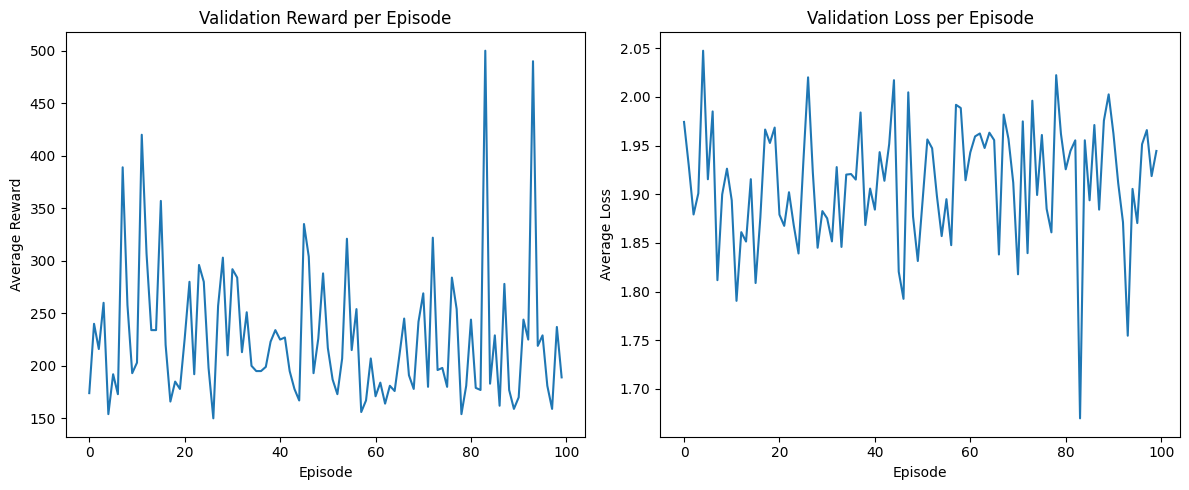

In [ ]:
# Load environment
env = gym.make("CartPole-v1")


agent = DQNAgent()
agent.model.load_weights("/content/dqn_cartpole_target_weights_2.h5")
agent.target_model.set_weights(agent.model.get_weights())

# Validation config
VALIDATION_EPISODES = 100
validation_rewards = []
validation_losses = []

# Running validation
for i in range(VALIDATION_EPISODES):
    avg_reward, avg_loss = validate_policy(agent, env, z, vmin, vmax, GAMMA, episodes=1)
    validation_rewards.append(avg_reward)
    validation_losses.append(avg_loss)

    print(f"Validation Episode {i+1}, Avg Reward: {avg_reward:.2f}, Avg Loss: {avg_loss:.4f}")

# Plot validation rewards and losses
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(validation_rewards)
plt.title("Validation Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Average Reward")

plt.subplot(1, 2, 2)
plt.plot(validation_losses)
plt.title("Validation Loss per Episode")
plt.xlabel("Episode")
plt.ylabel("Average Loss")

plt.tight_layout()
plt.show()

env.close()


In [ ]:
env = gym.make("CartPole-v1")  # no video recording

agent = DQNAgent()
agent.model.load_weights("/content/dqn_cartpole_target_weights_2.h5")

EPISODES = 50
episode_rewards = []
episode_losses = []

for episode in range(EPISODES):
    state, _ = env.reset()
    done = False
    episode_reward = 0
    losses = []

    while not done:
        state_input = np.expand_dims(state, axis=0)

        # Predict action distribution
        q_dists = agent.model.predict(state_input, verbose=0)[0]  # shape [actions, Natoms]
        q_values = np.sum(z * q_dists, axis=1)

        action = np.argmax(q_values)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Predict distribution for current and next state
        pred_dist = agent.model.predict(np.expand_dims(state, axis=0), verbose=0)[0]
        chosen_pred_dist = pred_dist[action]

        next_dist = agent.model.predict(np.expand_dims(next_state, axis=0), verbose=0)[0]
        next_q = np.sum(z * next_dist, axis=1)
        next_action = np.argmax(next_q)
        chosen_next_dist = next_dist[next_action]

        # Projected target distribution
        target_dist = project_distribution(
            chosen_next_dist[None, :],
            np.array([reward]),
            np.array([done]),
            GAMMA,
            z,
            vmin,
            vmax
        )

        # Compute loss (categorical crossentropy)
        loss = categorical_crossentropy_loss(target_dist, chosen_pred_dist[None, :])
        losses.append(loss.numpy())

        state = next_state
        episode_reward += reward

    avg_loss = np.mean(losses) if losses else 0
    episode_losses.append(avg_loss)
    episode_rewards.append(episode_reward)

    print(f"Episode {episode+1}: Reward = {episode_reward}, Loss = {avg_loss:.4f}")

env.close()

# Average reward over episodes
avg_reward = np.mean(episode_rewards)
print(f"\nAverage Reward over {EPISODES} episodes: {avg_reward:.2f}")

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(episode_losses)
plt.title("Validation Loss over Episodes")
plt.xlabel("Episode")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(episode_rewards)
plt.title("Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")

plt.tight_layout()
plt.show()


Episode 1: Reward = 183.0, Loss = 1.9688
Episode 2: Reward = 193.0, Loss = 1.9316
Episode 3: Reward = 181.0, Loss = 1.9417
Episode 4: Reward = 219.0, Loss = 1.8799
Episode 5: Reward = 185.0, Loss = 1.9335
Episode 6: Reward = 281.0, Loss = 1.8929
Episode 7: Reward = 186.0, Loss = 1.9634
Episode 8: Reward = 212.0, Loss = 1.9154
Episode 9: Reward = 169.0, Loss = 1.9839
Episode 10: Reward = 275.0, Loss = 1.8685


KeyboardInterrupt: 